<a href="https://colab.research.google.com/github/rade-ark/bldc/blob/main/BLDC_CNN_mel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install kaggle
!pip install torchinfo

from google.colab import files
files.upload()  # upload your kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d amirberenji/brushless-dc-motor-sound-dataset-for-pdm

# Unzip (adjust filename if different)
!unzip brushless-dc-motor-sound-dataset-for-pdm.zip -d ./data


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/amirberenji/brushless-dc-motor-sound-dataset-for-pdm
License(s): Attribution 4.0 International (CC BY 4.0)
brushless-dc-motor-sound-dataset-for-pdm.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  brushless-dc-motor-sound-dataset-for-pdm.zip
replace ./data/BLDC_sound_data/Bearing/M4/1700.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./data/BLDC_sound_data/Bearing/M4/1700.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/1750.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/1800.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/1850.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/1900.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/1950.wav  
  inflating: ./data/BLDC_sound_data/Bearing/M4/2000.wav  
  inflating: ./data/BLDC_sound_data/Healthy/M1/1400.wav  
  inflating: ./data/BLDC_sound_data/Healthy/M1/1450.wav  
  inflating: ./da

In [9]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
amirberenji_brushless_dc_motor_sound_dataset_for_pdm_path = kagglehub.dataset_download('amirberenji/brushless-dc-motor-sound-dataset-for-pdm')

print('Data source import complete.')


Using Colab cache for faster access to the 'brushless-dc-motor-sound-dataset-for-pdm' dataset.
Data source import complete.


# Importing essentical libraries

In [10]:
import os
import librosa
import numpy as np
import torch
import torch.nn.functional as F
from torchinfo import summary
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pydub import AudioSegment
import IPython

# Checking if the GPU is available

In [11]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU Runtime Detected")

else:
  device = torch.device("cpu")
  print("No GPU Found - CPU Runtime")

GPU Runtime Detected


# Loading the data

In [12]:
base_dir = './data/BLDC_sound_data/'


data = {
    'file_name': [],
    'motor': [],
    'state': [],
    'signal': [],
}

for state in os.listdir(base_dir):
    for motor in os.listdir(base_dir + state + '/'):
        for file in os.listdir(base_dir + state + '/' + motor + '/'):
            if file.endswith('.wav'):
                y, sr = librosa.load(base_dir + state + '/' + motor + '/' + file, sr = 16000)
                data['signal'].append(y[:160000])
                data['motor'].append(motor)
                data['state'].append(state)
                data['file_name'].append(file)

In [13]:
x = np.array(data['signal'])
x.shape

(43, 160000)

# Data preprocessing

## Splitting acoustic signals into sequences

In [14]:
def splitter(array, win_len, hop_len, return_df = True):
   N = array.shape[0]
   m = 0
   ids = []
   while m + win_len <= N:
      ids.append([m, m + win_len])
      m = m + hop_len

   if return_df:
      return pd.DataFrame([array[i[0]: i[1]] for i in ids])
   else:
      return np.array([array[i[0]: i[1]] for i in ids])

In [15]:
data_seqs = {
    'motor': [],
    'state': [],
    'signal': [],
}

for i in range(len(data['signal'])):
    arrays = splitter(data['signal'][i], 40000, 20000, return_df = False)
    for j in range(arrays.shape[0]):
        data_seqs['signal'].append(arrays[j, :])
        data_seqs['motor'].append(data['motor'][i])
        data_seqs['state'].append(data['state'][i])
np.array(data_seqs['signal']).shape

(301, 40000)

## Extracting Mel-Spectrograms

In [16]:
x = librosa.feature.melspectrogram(y = np.array(data_seqs['signal']), sr=16000, hop_length = 300)
x.shape

(301, 128, 134)

## Normalizing the Spectrograms

In [17]:
for i in range(x.shape[0]):
    x[i, :, :] = x[i, :, :] / np.max(x[i, :, :])

x = x.reshape(-1, 1, 128, 134)

## Target encoding

In [18]:
y = data_seqs['state']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

## Train/Test splitting

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.4, random_state = 42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(180, 1, 128, 134) (121, 1, 128, 134) (180,) (121,)


## Transforming *np.arrays* to *torch.Tensors*

In [20]:
x_train_train, x_train_validation, y_train_train, y_train_validation = train_test_split(x_train, y_train, test_size = 0.25)

x_train_VAR = torch.autograd.Variable(torch.Tensor(x_train_train).float()).to(device)
y_train_VAR = torch.autograd.Variable(torch.LongTensor(y_train_train)).to(device)
x_valid_VAR = torch.autograd.Variable(torch.Tensor(x_train_validation).float()).to(device)
y_valid_VAR = torch.autograd.Variable(torch.LongTensor(y_train_validation)).to(device)

x_test_VAR = torch.autograd.Variable(torch.Tensor(x_test).float()).to(device)

# Training a model

## Defining the model

In [21]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 15)
        self.avg1 = torch.nn.AvgPool2d(kernel_size = 7)
        self.conv2 = torch.nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 10)
        self.conv3 = torch.nn.Conv2d(in_channels = 20, out_channels = 40, kernel_size = 5)
        self.fc1 = torch.nn.Linear(480, 25)
        self.fc2 = torch.nn.Linear(25, 3)

    def forward(self, x):

        z = torch.tanh(self.conv1(x))
        z = self.avg1(z)
        z = torch.tanh(self.conv2(z))
        z = torch.tanh(self.conv3(z))

        z = z.reshape(-1, 480)
        z = torch.tanh(self.fc1(z))
        z = self.fc2(z)

        return z

In [22]:
model = Classifier()
summary(model, input_size=(1, 1, 128, 134))

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 3]                    --
├─Conv2d: 1-1                            [1, 10, 114, 120]         2,260
├─AvgPool2d: 1-2                         [1, 10, 16, 17]           --
├─Conv2d: 1-3                            [1, 20, 7, 8]             20,020
├─Conv2d: 1-4                            [1, 40, 3, 4]             20,040
├─Linear: 1-5                            [1, 25]                   12,025
├─Linear: 1-6                            [1, 3]                    78
Total params: 54,423
Trainable params: 54,423
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 32.29
Input size (MB): 0.07
Forward/backward pass size (MB): 1.11
Params size (MB): 0.22
Estimated Total Size (MB): 1.39

## Fitting the model

In [23]:
lr = 0.0025
ep = 1000

model = Classifier().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = lr,
                             weight_decay = lr / ep)

losses = []
valid_losses = []
accs = []
valid_accs = []



for epoch in range(ep):

  # validation step
  valid_loss = criterion(model(x_valid_VAR), y_valid_VAR).item()
  valid_losses.append(valid_loss)
  valid_acc = accuracy_score(y_train_validation, np.argmax(model(x_valid_VAR).cpu().detach().numpy(), axis = 1))
  valid_accs.append(valid_acc)

  # training step
  optimizer.zero_grad()
  loss = criterion(model(x_train_VAR), y_train_VAR)
  acc = accuracy_score(y_train_train, np.argmax(model(x_train_VAR).cpu().detach().numpy(), axis = 1))
  accs.append(acc)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  print(f"Epoch {epoch+1}, loss: {np.round(loss.item(), 4)}  , Vloss: {np.round(valid_loss, 4)}, acc: {np.round(acc, 4)}, Vacc: {np.round(valid_acc, 4)}")

Epoch 1, loss: 1.116  , Vloss: 1.1203, acc: 0.1852, Vacc: 0.1333
Epoch 2, loss: 1.0715  , Vloss: 1.0594, acc: 0.4815, Vacc: 0.5333
Epoch 3, loss: 1.066  , Vloss: 0.9785, acc: 0.4815, Vacc: 0.5333
Epoch 4, loss: 0.9999  , Vloss: 0.9406, acc: 0.5111, Vacc: 0.5333
Epoch 5, loss: 0.9804  , Vloss: 0.9042, acc: 0.6148, Vacc: 0.8222
Epoch 6, loss: 0.9538  , Vloss: 0.8178, acc: 0.5704, Vacc: 0.8222
Epoch 7, loss: 0.9028  , Vloss: 0.7319, acc: 0.563, Vacc: 0.7778
Epoch 8, loss: 0.8547  , Vloss: 0.6973, acc: 0.637, Vacc: 0.7778
Epoch 9, loss: 0.7858  , Vloss: 0.6548, acc: 0.6667, Vacc: 0.7778
Epoch 10, loss: 0.7177  , Vloss: 0.6533, acc: 0.7259, Vacc: 0.7556
Epoch 11, loss: 0.6345  , Vloss: 0.6419, acc: 0.7926, Vacc: 0.8
Epoch 12, loss: 0.5377  , Vloss: 0.5508, acc: 0.7926, Vacc: 0.8444
Epoch 13, loss: 0.5144  , Vloss: 0.5359, acc: 0.763, Vacc: 0.7778
Epoch 14, loss: 0.4448  , Vloss: 0.5526, acc: 0.8815, Vacc: 0.8889
Epoch 15, loss: 0.412  , Vloss: 0.5639, acc: 0.8741, Vacc: 0.8889
Epoch 16, los

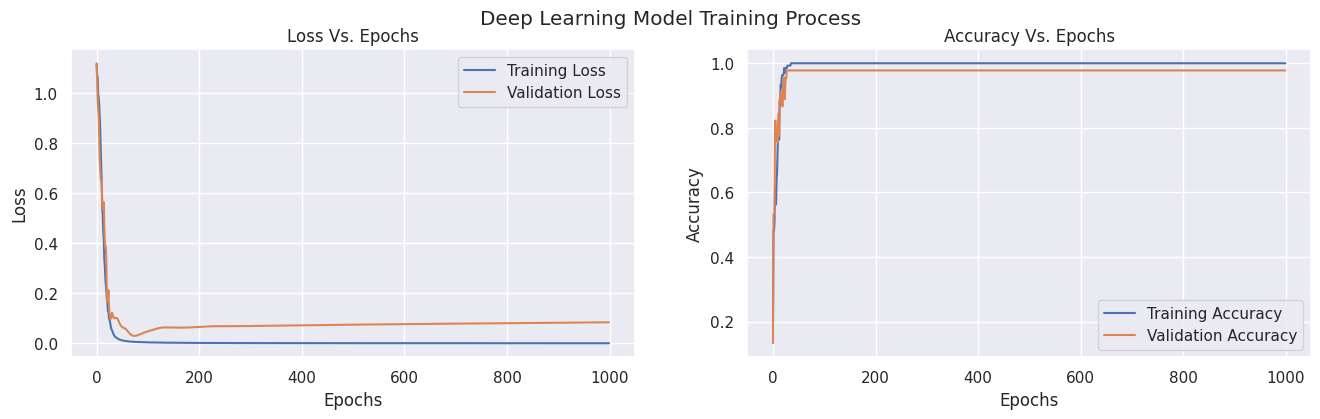

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))
fig.suptitle('Deep Learning Model Training Process')
axes[0].plot(losses, label='Training Loss')
axes[0].plot(valid_losses, label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Vs. Epochs')
axes[0].legend()

axes[1].plot(accs, label='Training Accuracy')
axes[1].plot(valid_accs, label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Vs. Epochs')
axes[1].legend()
plt.show()

# Performance evaluation

## Test-set accuracy

In [25]:
y_test_pred = np.argmax(F.softmax(model(x_test_VAR), dim = 0).cpu().detach().numpy(), axis = 1)
print('Test-set Classification Accuracy: ', np.round(accuracy_score(y_test, y_test_pred), 4))

Test-set Classification Accuracy:  0.9917


## Confusion Matrix

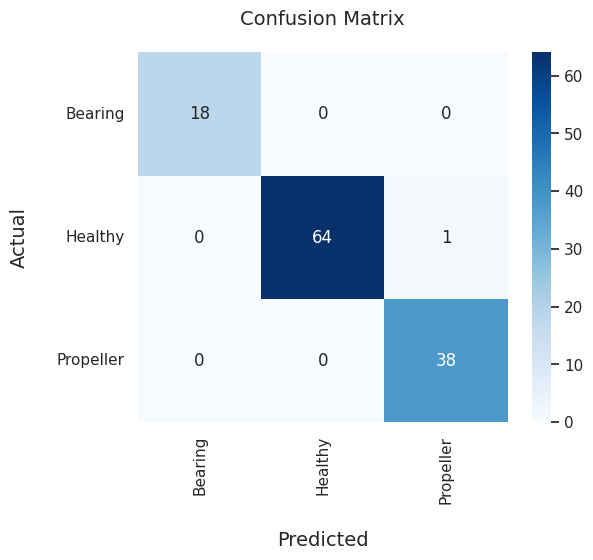

In [26]:
y_test_pred = np.argmax(F.softmax(model(x_test_VAR), dim = 0).cpu().detach().numpy(), axis = 1)
y_test_pred_decoded = le.inverse_transform(y_test_pred)
y_test_decoded = le.inverse_transform(y_test)

matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(matrix, annot=True, fmt='d', cbar = True, square = True, cmap = 'Blues')
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(np.unique(y_test_pred_decoded))
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(np.unique(y_test_pred_decoded))

plt.yticks(rotation=360)
plt.xticks(rotation=90)

ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()